# Text Detection Network With YOLO and MobileNetV2

This notebook uses is ICDAR 2013 dataset along with the YOLO Algorithm with MobileNetV2 weights to predict bounding boxes around text.

The model will then be used on the NYPL dataset to detext dishes on menus.

Notes:
- The ICDAR 2013 dataset is a text in the wild data set
- NYPL dataset is a dataset of scanned menus

In [0]:
# Import Libraries
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt

In [2]:
# Import Tensorflow 2.0
# Get TF 2.0
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part I: Data Preprocessing

This section of the notebook deals with preprocessing of data.
Data is read into arrays and passed into variables to be used for training and testing

In [0]:
# Define Path Variables
data_path = '/content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/'

train_data = data_path + 'Challenge2_Training_Task12_Images/Images/'
train_label = data_path + 'Challenge2_Training_Task1_GT/'
test_data = data_path + 'Challenge2_Test_Task12_Images/Images/'
test_label = data_path + 'Challenge2_Test_Task1_GT/'

In [5]:
# Define Temp Data Lists
training_images = []
training_labels = []
test_images = []
test_labels = []

# Generate list of data paths for training and test images and ground truths
# Get list of training_images
for file in os.listdir(train_data):
  training_images.append(train_data + file)

# Get list of training_labels
for file in os.listdir(train_label):
  training_labels.append(train_label + file)

# Get list of test_images
for file in os.listdir(test_data):
  test_images.append(test_data + file)

# Get list of test_labels
for file in os.listdir(test_label):
  test_labels.append(test_label + file)

print('Training Images:', len(training_images))
print('Training Ground Truths:', len(training_labels))
print('Test Images:', len(test_images))
print('Test Groud Truths:', len(test_labels))

Training Images: 228
Training Ground Truths: 228
Test Images: 233
Test Groud Truths: 233


In [6]:
# Check Paths
print('Training Image Path Check:\n', training_images[0], '\n')
print('Test Image Path Check:\n', test_images[0],'\n')
print('Training Label Path Check:\n', training_labels[0],'\n')
print('Test Label Path Check:\n', test_labels[0],'\n')

Training Image Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Training_Task12_Images/Images/174.jpg 

Test Image Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Test_Task12_Images/Images/img_10.jpg 

Training Label Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Training_Task1_GT/gt_293.txt 

Test Label Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Test_Task1_GT/gt_img_155.txt 



In [0]:
# Sort Data
training_images.sort()
training_labels.sort()
test_images.sort()
test_labels.sort()

In [8]:
# Check Paths Again (Image and Label should be the same)
print('Training Image Path Check:\n', training_images[0], '\n')
print('Training Label Path Check:\n', training_labels[0],'\n')
print('Test Image Path Check:\n', test_images[0],'\n')
print('Test Label Path Check:\n', test_labels[0],'\n')

Training Image Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Training_Task12_Images/Images/100.jpg 

Training Label Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Training_Task1_GT/gt_100.txt 

Test Image Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Test_Task12_Images/Images/img_1.jpg 

Test Label Path Check:
 /content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/Challenge2_Test_Task1_GT/gt_img_1.txt 



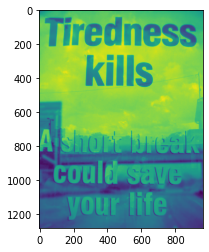

In [9]:
# Test that images are being read in correctly
img = cv2.imread(test_images[0], 0)
plt.imshow(img)

In [0]:
# Define Image Augmentation Variables
img_h = 512
img_w = 512
grid_h = 16
grid_w = 16

In [0]:
# REMOVE IMG FROM PARAMETERS
def rescale_anchor_box(gt, img_w, img_h, grid_w, grid_h, x_rescale_factor, y_rescale_factor, y_tmp, split_method):
  for text_box in gt:
    box = text_box.split(split_method)
    anchor_point = box[:4]

    # Get Rescaled Anchor Points
    x_min = int(anchor_point[0]) * x_rescale_factor         # Left most X
    x_max = int(anchor_point[2]) * x_rescale_factor         # Right most X
    y_min = int(anchor_point[1]) * y_rescale_factor         # Lower most Y
    y_max = int(anchor_point[3]) * y_rescale_factor         # Upper most Y

    # Get Scaled Height and Width of Anchor Box
    scaled_w = (x_max - x_min) / img_w                      # Scaled width
    scaled_h = (y_max - y_min) / img_h                      # Scaled height
    scaled_x = ((x_min + x_max)/2)/img_w
    scaled_x = scaled_x * grid_w                            # Scaled X range (original)
    scaled_y = ((y_min + y_max)/2)/img_h
    scaled_y = scaled_y * grid_h                            # Scaled Y range (original)

    # Reconstruct Anchor Box
    y_tmp[int(scaled_y), int(scaled_x), 0, 0] = 1
    y_tmp[int(scaled_y), int(scaled_x), 0, 1] = scaled_x - int(scaled_x)
    y_tmp[int(scaled_y), int(scaled_x), 0, 2] = scaled_y - int(scaled_y)
    y_tmp[int(scaled_y), int(scaled_x), 0, 3] = scaled_w
    y_tmp[int(scaled_y), int(scaled_x), 0, 4] = scaled_h

  return y_tmp

In [0]:
def preprocess_images_labels(images, labels, img_h, img_w, grid_h, grid_w, split_method):
  
  # Reshape Images and Labels
  X = []
  y = []
  counter = 1

  # Scale and Normalize Image Data
  for i in range(len(images)):
    
    # Images
    img = images[i]
    org_img = cv2.imread(img)
    x_rescale_factor = 512/org_img.shape[1]
    y_rescale_factor = 512/org_img.shape[0]
    img_rescaled = cv2.resize(org_img, (img_h, img_w))

    X.append(img_rescaled)

    # Ground Truths
    y_tmp = np.zeros((grid_h, grid_w, 1, 5))
    org_gt_file_loc = labels[i]
    with open(org_gt_file_loc, 'r') as f:
      gt = f.read()
      gt = gt.split('\n')
      gt = gt[:-1]

    scaled_anchor_box = rescale_anchor_box(gt, img_w, img_h, grid_w, grid_h, x_rescale_factor, y_rescale_factor, y_tmp, split_method)

    y.append(scaled_anchor_box)

    if counter % 50 == 0:
      print('Completed Iteration:', counter)
    counter += 1

  # Convert to np array
  X = np.array(X)
  y = np.array(y)

  # Normalize X
  X = (X - 127.5) / 127.5

  return X, y

In [13]:
X_train, y_train = preprocess_images_labels(training_images, training_labels, img_h, img_w, grid_h, grid_w, split_method = ' ')
X_test, y_test = preprocess_images_labels(test_images, test_labels, img_h, img_w, grid_h, grid_w, split_method = ', ')

Completed Iteration: 50
Completed Iteration: 100
Completed Iteration: 150
Completed Iteration: 200
Completed Iteration: 50
Completed Iteration: 100
Completed Iteration: 150
Completed Iteration: 200


In [14]:
# Merge Train and Test Data
# We will separate them later using Sklearns train_test_split method
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print('Image Shape:', X.shape)
print('Ground Truth Shape:', y.shape)

Image Shape: (461, 512, 512, 3)
Ground Truth Shape: (461, 16, 16, 1, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


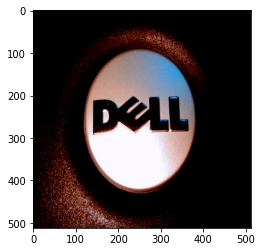

In [15]:
tmp = X[1]
plt.imshow(tmp)

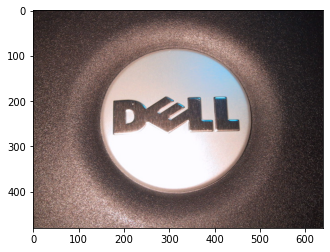

In [16]:
tmp2 = cv2.imread(training_images[1])
plt.imshow(tmp2)

## Part II: Model Creation

In this section of the notebook, we will generate the YOLO model using MobileNetV2 with 'imagenet' weights.

In [0]:
# Import Libraries
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, Activation, BatchNormalization, Dropout, Input, LeakyReLU
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model

### Model

The YOLO algorithm is a single-shot detection algorithm that uses object classification to detect objects. Once an object is classified a bounding box is applied to it, and regressed to find the optimal position.

In [0]:
def yolo_model(input_shape):
  """ DOC STRING """
  # Load MobileNetV2
  mobile_net = MobileNetV2(input_shape = input_shape, weights = 'imagenet', include_top = False)
  mobile_net.trainable = False
  
  # Build ConvNet to Detect Text In Images
  # Conv1
  conv1 = Conv2D(512, kernel_size = (3,3), padding = 'same', activation = 'relu')(mobile_net.output)
  do1 = Dropout(0.5)(conv1)
  bn1 = BatchNormalization()(do1)
  relu1 = LeakyReLU(alpha=0.3)(bn1)
  #maxpool1 = MaxPool2D(pool_size=(3,3))(relu1)

  # Conv2
  conv2 = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu')(relu1)
  do2 = Dropout(0.5)(conv2)
  bn2 = BatchNormalization()(do2)
  relu2 = LeakyReLU(alpha=0.3)(bn2)
  #maxpool2 = MaxPool2D(pool_size=(3,3))(relu2)

  # Final Conv
  conv3 = Conv2D(filters = 5, kernel_size = (3,3), padding = 'same', activation = 'relu')(relu2)
  relu3 = LeakyReLU(alpha=0.3)(conv3)
  output = Reshape((16, 16, 1, 5))(relu3)

  # Model
  model = Model(inputs = mobile_net.input, outputs = output)

  return model

### Loss Function

 The YOLO loss function is broken down into 3 components:
 1. Classification Loss - IF an object is detected, is it of the correct class 
 2. Localization Loss - Error between the predicted bounding box and the ground 
truth
 3. Confidence Loss - The objectness of the box (Is there an object (in our case text) in the box)
- If no object is detected, the confidence function weighs down the loss when detecting background

Combining these three loss terms gives us the loss of a training example when using the yolo algorithm

In [0]:
def yolo_loss(y, pred):
  """ Loss function for yolo for text detection """
  # Define Lambda variables
  lambda_coord = 5.0
  lambda_no_obj = 0.5

  # Predefine function variables
  coord = y[:,:,:,:,0] * lambda_coord
  no_obj = -1 * (y[:,:,:,:,0] - 1) * lambda_no_obj
  prob_true = y[:,:,:,:,0]                            # True objectness
  prob_pred = pred[:,:,:,:,0]                         # Predicted objectness
  x_true = y[:,:,:,:,1]                               # True x point
  x_pred = pred[:,:,:,:,1]                            # Predicted x point
  y_true = y[:,:,:,:,2]                               # True y point
  y_pred = pred[:,:,:,:,2]                            # Predicted y point
  w_true = y[:,:,:,:,3]                               # True width
  w_pred = pred[:,:,:,:,3]                            # Predicted width
  h_true = y[:,:,:,:,4]                               # True height
  h_pred = pred[:,:,:,:,4]                            # Predicted heigh

  # 1. Classification Loss
  class_loss = tf.keras.losses.binary_crossentropy(prob_true, prob_pred)

  # 2. Localization loss
  xy_loss = tf.reduce_sum(tf.square([x_pred - x_true]) * coord) + tf.reduce_sum(tf.square([y_pred - y_true]) * coord)
  wh_loss = tf.reduce_sum(tf.square([tf.sqrt(w_pred) - tf.sqrt(w_true)]) * coord) + tf.reduce_sum(tf.square([tf.sqrt(h_pred) - tf.sqrt(h_true)]) * coord)
  local_loss = xy_loss + wh_loss

  # 3. Confidence Loss
  # Class Present
  prob_present = tf.reduce_sum(tf.square([prob_pred - prob_true]))

  # Class Absent
  prob_absent = tf.reduce_sum(tf.square([prob_pred - prob_true]) * no_obj)

  # Total Loss
  loss = local_loss + prob_present + prob_absent + class_loss

  return loss

## Part III: Training

This section of the notebook covers how to train the YOLO algorithm. The preprocessed data is called and split using train_test_split. We use an 'Adam' optimizer to optimize the algorithm, and the loss is determined based on our loss function (defined earlier in the notebook). We train for XXXXX epochs and report the loss and other metrics in Part IV.

In [0]:
# Import Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

### Model Checkpoints

In [0]:
# Setup Model Checkpoints

# Create new folder
callback_dir = '/content/drive/My Drive/Menu_Parser_Datasets/Callbacks/Text_Detection/'
today = datetime.now()                    # Get Runtime
today = today.strftime('%Y%m%d%H%M%S')    # Convert to folder string
callback_path = callback_dir + today

os.mkdir(callback_path)            # Create new folder for callbacks

# Checkpoint
checkpoint = ModelCheckpoint(callback_path, monitor = 'val_loss', verbose = 0, save_best_only=True, mode = 'min')

### Split Data

In [22]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
print('Train Size:', len(X_train))
print('Test Size:', len(X_test))

Train Size: 414
Test Size: 47


### Build and Compile Model

In [23]:
# Build Model
channels = 3
input_shape = (img_w, img_h, channels)
model = yolo_model(input_shape)

# Define Optimizer
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)

# Load Weights
model.load_weights('/content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/yolo/yolo_weights.h5')

# Compile Model
model.compile(optimizer = adam, loss = yolo_loss, metrics = ['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


### Model Summary

In [24]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

### Model Training

In [26]:
# Fit Model
history = model.fit(x = X_train, y = y_train, epochs = 50, batch_size = 2, callbacks = [checkpoint], validation_data= (X_test, y_test))

Epoch 1/50
207/207 [==============================] - 4s 18ms/step - loss: 1.6436 - accuracy: 0.0231 - val_loss: 8.2872 - val_accuracy: 0.0169
Epoch 2/50
207/207 [==============================] - 19s 92ms/step - loss: 1.6014 - accuracy: 0.0218 - val_loss: 8.2258 - val_accuracy: 0.0155
Epoch 3/50
207/207 [==============================] - 20s 95ms/step - loss: 1.6004 - accuracy: 0.0206 - val_loss: 8.2115 - val_accuracy: 0.0155
Epoch 4/50
207/207 [==============================] - 4s 17ms/step - loss: 1.5903 - accuracy: 0.0213 - val_loss: 8.2142 - val_accuracy: 0.0148
Epoch 5/50
207/207 [==============================] - 20s 98ms/step - loss: 1.5825 - accuracy: 0.0207 - val_loss: 8.1783 - val_accuracy: 0.0153
Epoch 6/50
207/207 [==============================] - 4s 17ms/step - loss: 1.5536 - accuracy: 0.0223 - val_loss: 8.2126 - val_accuracy: 0.0157
Epoch 7/50
207/207 [==============================] - 4s 18ms/step - loss: 1.4865 - accuracy: 0.0239 - val_loss: 8.1853 - val_accuracy: 0.0

In [0]:
# Save Model
#model.save('/content/drive/My Drive/Menu_Parser_Datasets/ICDAR 2013/yolo/yolo_weights.h5')

## Part IV: Model Validation

This section of the notebook will check the performance of the model

### Intersection Over Union

This function gets the intersection over union for the bounding boxes

In [0]:
def intersectionOverUnion(box1, box2):
  """ This function predicts the Intersection Over Union for bounding boxes """

  # Get Upper Left and Lower Right positions
  x1 = max(box1[0], box2[0])
  x2 = min(box1[2], box2[2])
  y1 = max(box1[1], box2[1])
  y2 = min(box1[3], box2[3])

  # Calculate Intersection
  intersection = (x2 - x1) * (y2 - y1)

  # Calculate Area of each box
  area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
  area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

  # Calculate Total Area
  total_area = area1 + area2 - intersection

  # Find IOU
  iou = intersection/total_area

  return iou

### Non-Max Suppression
This Function calculates non-max suppression on the bounding boxes

In [0]:
def non_max_suppression(boxes, scores, iou):
  """ This Function Selects the most optimal bounding box """

  # Sort incoming scores and create keep list
  sorted_scores = scores.argsort().tolist()
  keep = []
  
  while(len(sorted_scores)):
    index = sorted_scores.pop()
    keep.append(index)

    if len(sorted_scores) == 0:
      break

    iou_results = []

    for i in sorted_scores:
      
      # Calculate IOU for each bounding box and append result to list
      iou_results.append(intersectionOverUnion(boxes[index], boxes[i]))

    # Convert list to np array
    iou_results = np.array(iou_results)

    # Remove all boxes that are less than iou threshold
    filtered_index = set((iou_results > iou).nonzero()[0])
    
    # create list of sorted scores that are not in filtered_index
    sorted_scores = [v for (i,v) in enumerate(sorted_scores) if i not in filtered_index]

  final = []

  for i in keep:
    final.append(boxes[i])

  # Return final result
  return final

### Matrix Output to Bounding Box
This function converts the model output into bounding boxes that can be drawn using openCV

In [0]:
def mat_to_bounding_box(output, img_h, img_w):
  """ This function converts the output to bounding boxes that can be drawn using cv2 """

  # Define Variables
  threshold = 0.5                                               # Threshold for box
  grid_h = output.shape[1]                                      # Image height
  grid_w = output.shape[0]                                      # Image Width
  boxes = []                                                    # Boxes
  scores = []                                                   # Score

  # Iterate over columns and rows
  for i in range(grid_h):
    for j in range(grid_w):

      # It output is greater than threshold
      if output[i,j,0,0] > threshold:
        tmp_out = output[i,j,0,1:5]
        x_point = (((j + tmp_out[0]) / grid_w) * img_w)         # Get X location
        y_point = (((i + tmp_out[1]) / grid_h) * img_h)         # Get Y location
        width = tmp_out[2] * img_w * 1.3                        # Get Width
        height = tmp_out[3] * img_h * 1.3                       # Get Height

        # Create top left and bottom right points using half width and height
        # x +- half width; y +- half height
        boxes.append([(x_point - (width/2)), (y_point - (height/2)), (x_point + (width/2)), (y_point + (height/2))])

        # Get object score
        scores.append(output[i,j,0,0])

  # Return boxes and scores
  return boxes, scores

### Model Validation
This section is used to validate outputs
1. The decode function calls mat_to_bounding_box (Described above)
2. The predict function calls decode, and draws bounding boxes on the images

In [0]:
def decode(output, h, w, iou):
  """ decode output into bounding boxes """
  boxes, scores = mat_to_bounding_box(output, h, w)           # Convert output to boxes
  boxes = non_max_suppression(boxes, np.array(scores), iou)   # Get boxes after suppression
  return boxes

In [0]:
def predict_function(model, input_image, iou, name):
  """ Display bounding text boxes on image """
  # Run prediction on image
  pred = model.predict(input_image)

  # Get bounding boxes
  boxes = decode(pred[0], img_h, img_w, iou)

  # Scale Image
  img = ((input_image + 1) / 2)
  img = img[0]

  # Draw Boxes
  for i in boxes:
    i = [int(x) for x in i]
    img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)
  
  # Show Image
  plt.imshow(img)
  plt.show()

  # Return Image
  return img

## Part V: Examples

This section of the notebook covers examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


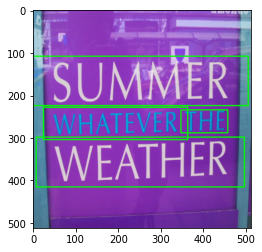

In [33]:
ans = predict_function(model, X_train[0:1], 0.5, 'i')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


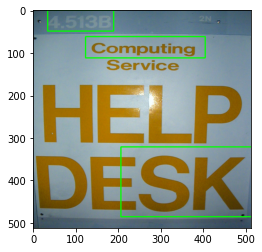

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


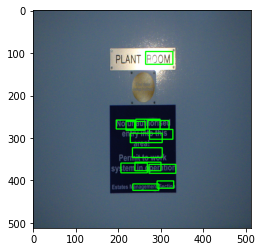

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


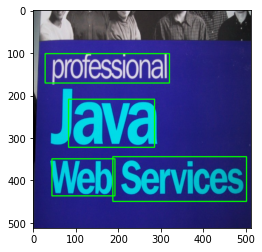

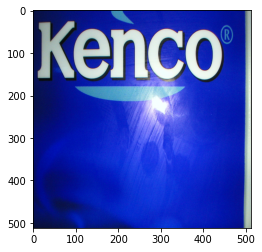

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


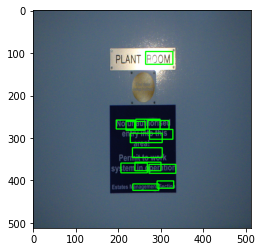

In [35]:
rand = np.random.randint(0,X_test.shape[0], size = 5)

for i in rand:    
    predict_function(model , X_test[i:i+1] , 0.5, i)